In [1]:
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [2]:
DOWNLOAD_ROOT = 'https://www.kaggle.com/datasets/williamu32/imoveis-goiniago/download'
HOUSING_PATH = os.path.join('datasets')
DATA_FILENAME = 'housing.csv'

In [3]:
def fetch_data() -> pd.DataFrame:
    return pd.read_csv(os.path.join(HOUSING_PATH, DATA_FILENAME))

In [4]:
df = fetch_data()
df.head(5)

,DATE,PRICE,ADDRESS,AREAS,BEDROOMS,PARKING-SPACES,BATHROOMS,CONDOMÍNIO,IPTU,TIPO
0,2021-08-05 16:34:17.725797-03:00,Sob consulta,"Rua João de Abreu, Setor Oeste",222 - 485 m²,3 - 4,2 - 4,3 - 5,NaN,NaN,apartamentos
1,2021-08-05 16:34:17.726263-03:00,R$ 430.000,"Rua R 7, Setor Oeste",66 - 68 m²,2,2,2 - 3,NaN,NaN,apartamentos
2,2021-08-05 16:34:17.726628-03:00,R$ 345.000,"Rua 7, Setor Oeste",34 - 76 m²,1 - 2,1,1,NaN,NaN,apartamentos
3,2021-08-05 16:34:17.726966-03:00,R$ 420.000,"Setor Bueno, Goiânia",89 m²,3,1,2,NaN,NaN,apartamentos
4,2021-08-05 16:34:17.727328-03:00,R$ 1.018.000,"Setor Bueno, Goiânia",175 m²,4,5,4,R$ 650,R$ 2.000,apartamentos


# Transfomers

In [5]:
class PriceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, price_ix):
        self.price_ix = price_ix
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X[X.columns[self.price_ix]].replace(['R\$ ', '\.'], '', inplace=True, regex=True)
        X[X.columns[self.price_ix]] = pd.to_numeric(X[X.columns[self.price_ix]], errors='coerce')
        X[X.columns[self.price_ix]] = X[X.columns[self.price_ix]].astype(float)
        
        return X

In [6]:
class AreaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, area_ix):
        self.area_ix = area_ix
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        X[X.columns[self.area_ix]].replace(' m²', '', regex=True, inplace=True)
        X[X.columns[self.area_ix]] = X.iloc[:, self.area_ix].str.split(' - ')
        X[X.columns[self.area_ix]] = X.iloc[:, self.area_ix].apply(lambda x : list(map(float, x)) if isinstance(x, list) else x)
        X[X.columns[self.area_ix]] = X.iloc[:, self.area_ix].apply(np.mean)
        
        return X

In [7]:
class ColumnDropperTransfomer(BaseEstimator, TransformerMixin):
    def __init__(self, data_ix, condominio_ix, iptu_ix, del_data=True, del_condominio=True, del_IPTU=True):
        self.data_ix = data_ix
        self.condominio_ix = condominio_ix
        self.iptu_ix = iptu_ix
        self.del_data = True
        self.del_condominio = True
        self.del_IPTU = True
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        c = 0
        
        if self.del_data:
            X = X.drop(X.columns[self.data_ix], axis=1) # Deleta data
            c += 1
        
        if self.del_condominio:
            X = X.drop(X.columns[self.condominio_ix - c], axis=1)  # Deleta Condominio
            c += 1
            
        if self.del_IPTU:
            X = X.drop(X.columns[self.iptu_ix - c], axis=1)  # Deleta IPTU
        
        return X

In [8]:
class BedroomsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bedrooms_ix):
        self.bedrooms_ix = bedrooms_ix
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        X[X.columns[self.bedrooms_ix]] = X.iloc[:, self.bedrooms_ix].str.split(' - ')
        X[X.columns[self.bedrooms_ix]] = X.iloc[:, self.bedrooms_ix].apply(lambda x : list(map(float, x)) if isinstance(x, list) else x)
        X[X.columns[self.bedrooms_ix]] = X.iloc[:, self.bedrooms_ix].apply(np.mean)

        return X

In [9]:
class ParkingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, parking_ix):
        self.parking_ix = parking_ix
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        X[X.columns[self.parking_ix]] = X.iloc[:, self.parking_ix].str.split(' - ')
        X[X.columns[self.parking_ix]] = X.iloc[:, self.parking_ix].apply(lambda x : list(map(float, x)) if isinstance(x, list) else x)
        X[X.columns[self.parking_ix]] = X.iloc[:, self.parking_ix].apply(np.mean)

        return X

In [10]:
class BathroomsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bathrooms_ix):
        self.bathrooms_ix = bathrooms_ix
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        X[X.columns[self.bathrooms_ix]] = X.iloc[:, self.bathrooms_ix].str.split(' - ')
        X[X.columns[self.bathrooms_ix]] = X.iloc[:, self.bathrooms_ix].apply(lambda x : list(map(float, x)) if isinstance(x, list) else x)
        X[X.columns[self.bathrooms_ix]] = X.iloc[:, self.bathrooms_ix].apply(np.mean)

        return X

In [11]:
class RemoveOutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns:list[str]):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        for column in X.columns:
            if column in self.columns:
                Q1 = X[column].quantile(0.25)
                Q3 = X[column].quantile(0.75)
                IQR = Q3 - Q1
                Lower_Whisker = Q1 - 1.5 * IQR
                Upper_Whisker = Q3 + 1.5 * IQR
                
                if (Lower_Whisker < 0):
                    Lower_Whisker = 0
                
                X.drop(X[(X[column] <= Lower_Whisker) | (X[column] >= Upper_Whisker)].index, axis=0, inplace=True)
                
        return X

In [12]:
class RemoveNANTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X).dropna()
                
        return X

# Pipeline

In [13]:
price_ix, area_ix, bedrooms_ix, parking_ix, bathroom_ix = 0, 1, 2, 3, 4
num_attrs = ['AREAS', 'BEDROOMS', 'PARKING-SPACES', 'BATHROOMS']


num_pipeline = Pipeline([
    ('price', PriceTransformer(price_ix)),
    ('area', AreaTransformer(area_ix)),
    ('bedroom', BedroomsTransformer(bedrooms_ix)),
    ('parking', ParkingTransformer(parking_ix)),
    ('bathroom', BathroomsTransformer(bathroom_ix))
])

columns_trans = ColumnTransformer([
    ('num', num_pipeline, ['PRICE', 'AREAS', 'BEDROOMS', 'PARKING-SPACES', 'BATHROOMS']),
    ('cat', OneHotEncoder(), ['TIPO'])
])

full_pipeline = Pipeline([
    ('pre', columns_trans),
    ('remove_na', RemoveNANTransformer()),
    ('outliers', RemoveOutliersTransformer(columns=[price_ix, area_ix, parking_ix, bathroom_ix]))
])

full_pipeline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('price',
                                                                   PriceTransformer(price_ix=0)),
                                                                  ('area',
                                                                   AreaTransformer(area_ix=1)),
                                                                  ('bedroom',
                                                                   BedroomsTransformer(bedrooms_ix=2)),
                                                                  ('parking',
                                                                   ParkingTransformer(parking_ix=3)),
                                                                  ('bathroom',
                                                                   BathroomsTransformer(bathrooms_ix=4))]),
                                                  ['PRICE', 'AREAS', 'BEDROOMS',
                                                   'PARKING-SPACES',
                                                   'BATHROOMS']),
                                                 ('cat', OneHotEncoder(),
                                                  ['TIPO'])])),
                ('remove_na', RemoveNANTransformer()),
                ('outliers', RemoveOutliersTransformer(columns=[0, 1, 3, 4]))])

In [14]:
df = fetch_data()
df.drop(columns=['DATE', 'ADDRESS', 'CONDOMÍNIO', 'IPTU'], inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42) 

for train_index, test_index in split.split(df, df['TIPO']):
    strat_train_set = df.iloc[train_index] 
    strat_test_set = df.iloc[test_index]

In [15]:
train_data_prepared = full_pipeline.fit_transform(strat_train_set)
test_data_prepared = full_pipeline.fit_transform(strat_test_set)

In [16]:
train_data_prepared_df = pd.DataFrame(train_data_prepared)
test_data_prepared_df = pd.DataFrame(test_data_prepared)

Y_train = train_data_prepared_df[0]
X_train = train_data_prepared_df.drop(0, axis=1).copy()

Y_test = test_data_prepared_df[0]
X_test = test_data_prepared_df.drop(0, axis=1).copy()

In [17]:
print('Type \t Len X \t Len Y')
print(f'Train \t {len(X_train)} \t {len(Y_train)}')
print(f'Test \t {len(X_test)} \t {len(Y_test)}')

Type 	 Len X 	 Len Y
Train 	 12774 	 12774
Test 	 2761 	 2761


# Exploração dos Dados

In [18]:
c = [x for x in fetch_data().columns if x not in ('DATE', 'ADDRESS', 'CONDOMÍNIO', 'IPTU', 'TIPO')]
df = pd.DataFrame(data=train_data_prepared.to_numpy()[:, 0: 5], columns=c)

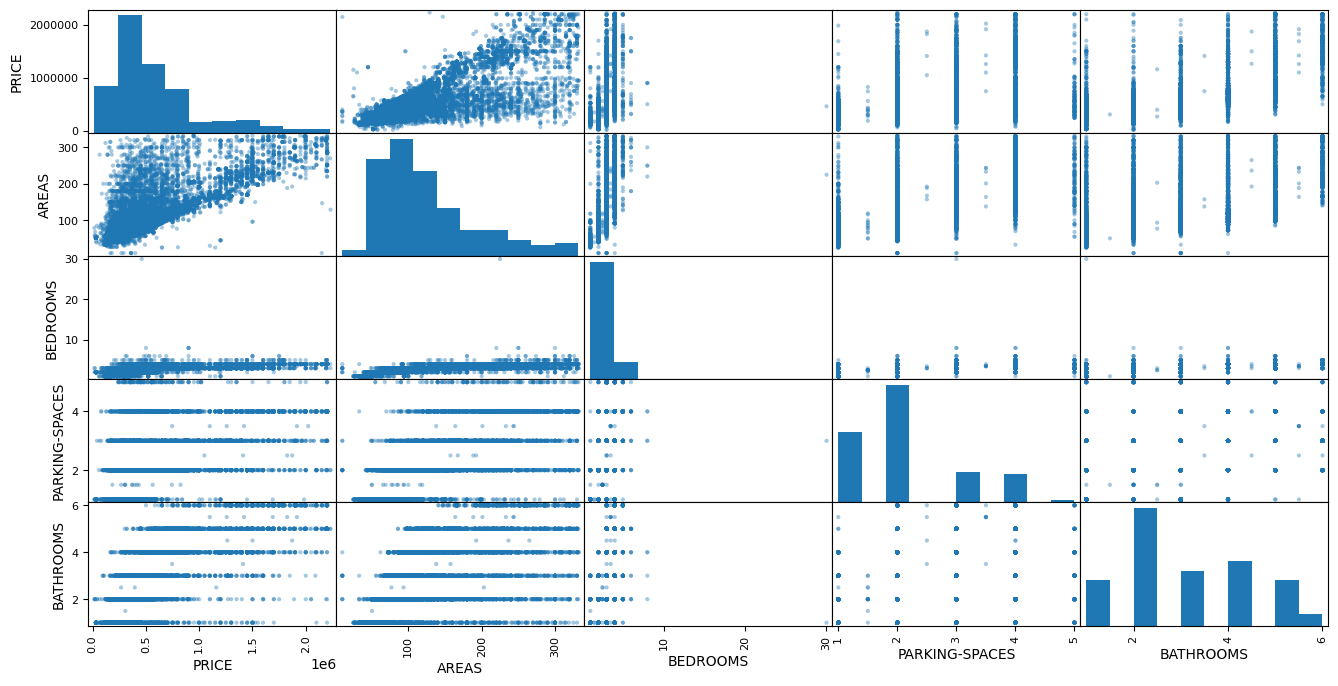

In [19]:
scatter_matrix(df, marker='.', alpha=.4, figsize=(16, 8));

Possível relação linear entre Area e Preço

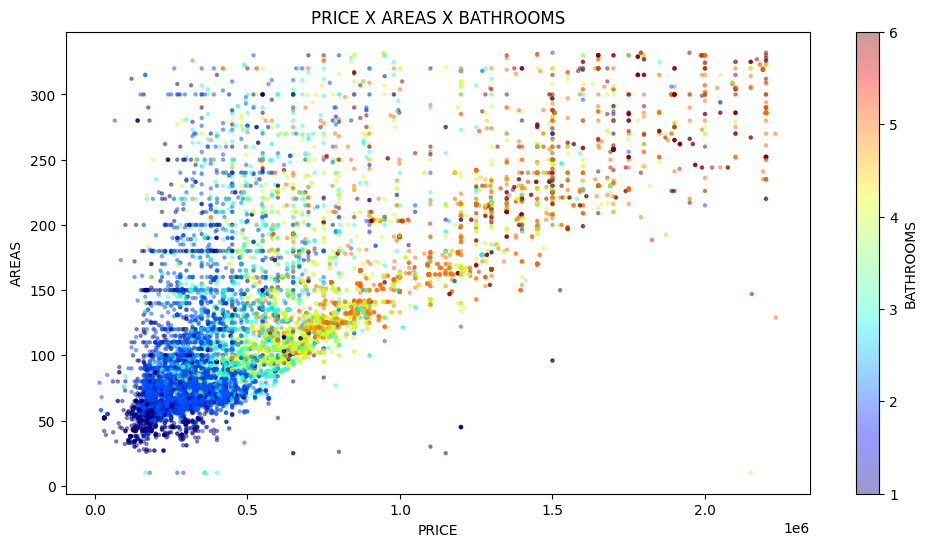

In [20]:
df.plot(kind='scatter', x='PRICE', y='AREAS', c='BATHROOMS', 
        figsize=(12, 6),
        marker='.', alpha=.4, cmap=plt.get_cmap('jet'), colorbar=True);
plt.title('PRICE X AREAS X BATHROOMS')
plt.show()

In [21]:
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,PRICE,AREAS,BEDROOMS,PARKING-SPACES,BATHROOMS
PRICE,1.000000,0.746156,0.524231,0.592564,0.732971
AREAS,0.746156,1.000000,0.618064,0.737307,0.560844
BEDROOMS,0.524231,0.618064,1.000000,0.524304,0.551689
PARKING-SPACES,0.592564,0.737307,0.524304,1.000000,0.481211
BATHROOMS,0.732971,0.560844,0.551689,0.481211,1.000000


Boa relação de preço com área

# Treinando Modelo

## Regressão Linear

In [22]:
lin_reg = LinearRegression()

In [23]:
lin_reg.fit(X_train, Y_train)

LinearRegression()

### Testando Modelo

In [24]:
def plotRegressor(y_test, y_pred, regressorName:str='', figsize=(20, 8)):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue', alpha=.1, marker='.', label='True')
    plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=.1, marker='.', label='Predict')
    plt.legend()
    plt.title(regressorName)
    plt.show()

In [25]:
final_predictions = lin_reg.predict(X_test)

final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

171934.35881931812

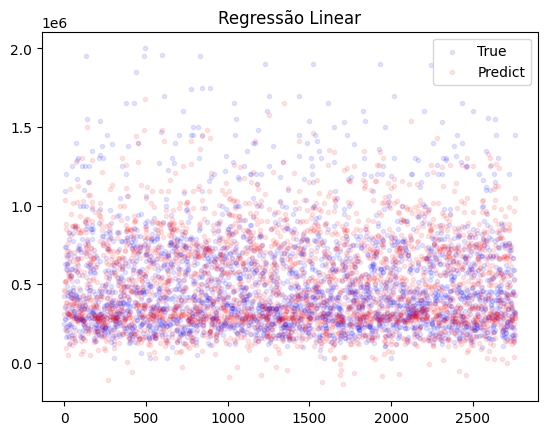

In [26]:
plotRegressor(Y_test, final_predictions, 'Regressão Linear')

## Random Forest Regressor

In [27]:
rnd_for = RandomForestRegressor()
rnd_for.fit(X_train, Y_train)

RandomForestRegressor()

### Testando Modelo

In [28]:
final_predictions = rnd_for.predict(X_test)

final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

124927.17826656597

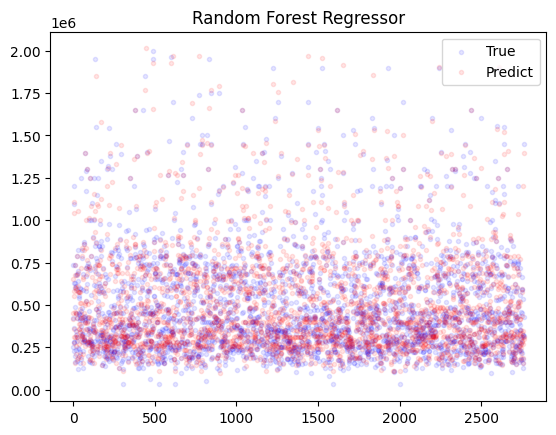

In [29]:
plotRegressor(Y_test, final_predictions, 'Random Forest Regressor')

# Tentando Melhorar Modelo

## Random Forest Regressor

In [30]:
dist = {
    'n_estimators' : [x for x in range (10, 101, 10)],
    'max_features' : [x for x in range(20, 51, 5)],
    'max_depth' : [x for x in range(20, 51, 5)],
}

random_search = RandomizedSearchCV(rnd_for, dist, cv=5, n_iter=30,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

random_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=30,
                   param_distributions={'max_depth': [20, 25, 30, 35, 40, 45,
                                                      50],
                                        'max_features': [20, 25, 30, 35, 40, 45,
                                                         50],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   return_train_score=True, scoring='neg_mean_squared_error')

In [31]:
random_search.best_estimator_

RandomForestRegressor(max_depth=40, max_features=20)

In [32]:
predict_values = random_search.best_estimator_.predict(X_test)
final_mse = mean_squared_error(Y_test, predict_values)
final_rmse = np.sqrt(final_mse)
final_rmse

125142.9820504726

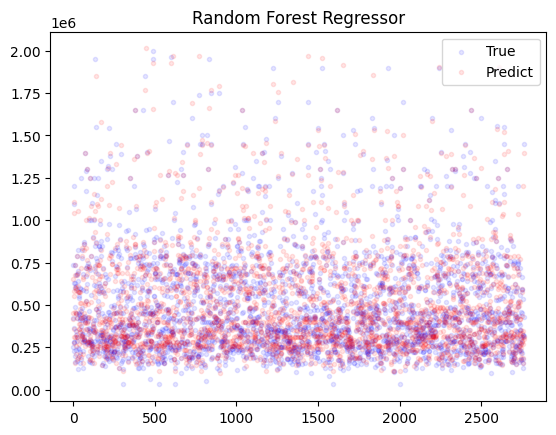

In [33]:
plotRegressor(Y_test, final_predictions, 'Random Forest Regressor')

# Salvando Modelo

In [34]:
MODELS_PATH = os.path.join("models")
os.makedirs(MODELS_PATH, exist_ok=True)

joblib.dump(lin_reg, MODELS_PATH + '\model_linear_reg.pkl')
joblib.dump(random_search.best_estimator_, MODELS_PATH + '\model_tree_regressor.pkl');